In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import kabuki
import seaborn as sns
%matplotlib inline
import hddm
print(hddm.__version__)

0.8.0


/opt/homebrew/Caskroom/miniforge/base/envs/pyHDDM/lib/python3.6/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
def read_models(filepath, n_chains=4):
    models=[]
    for i in range(n_chains):    
        models.append(hddm.load(f'{filepath}_{i}model'))
    return kabuki.utils.concat_models(models)

In [3]:
def hdi(ary, hdi_prob):
    """Compute hpi over the flattened array."""
    ary = ary.flatten()

    n = len(ary)


    ary = np.sort(ary)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float_)

    if len(interval_width) == 0:
        raise ValueError("Too few elements for interval calculation. ")

    min_idx = np.argmin(interval_width)
    hdi_min = ary[min_idx]
    hdi_max = ary[min_idx + interval_idx_inc]

    hdi_interval = np.array([hdi_min, hdi_max])

    return hdi_interval


In [4]:
def extract_params(model, contains=None):
    stats = model.gen_stats()
    if contains is not None:
        out = stats[stats.index.str.contains(contains,na=False)]
    else:
        out = stats
    return out 

def ttests(model_hia, model_loa, params=['a','t','v','z'], trials='101'):

    for param in params:
        hia = extract_params(model_hia, f'{param}_subj\({trials}\)')
        loa = extract_params(model_loa, f'{param}_subj\({trials}\)')
        h,p = scipy.stats.ttest_ind(hia['mean'], loa['mean'])
        print(f't-test {param} {trials} - p = {p:.4f} - t = {h:.4f}')

def compute_hdi(hia_101, loa_101, hia_102, loa_102, parameter_name, interval=0.95):
    hdi_hia_101 = hdi(hia_101.trace(), interval)
    hdi_loa_101 = hdi(loa_101.trace(), interval)

    hdi_diff_101 = hdi(hia_101.trace() - loa_101.trace(), interval)

    hdi_hia_102 = hdi(hia_102.trace(), interval)
    hdi_loa_102 = hdi(loa_102.trace(), interval)

    hdi_diff_102 = hdi(hia_102.trace() - loa_102.trace(), interval)

    print('mixed gamble')
    print(f'{parameter_name} {interval} HDI high anx = {hdi_hia_101}')
    print(f'{parameter_name} {interval} HDI low anx = {hdi_loa_101}')
    print(f'{parameter_name} {interval} HDI difference = {hdi_diff_101}')
    print()
    print('gain only')
    print(f'{parameter_name} {interval} HDI high anx = {hdi_hia_102}')
    print(f'{parameter_name} {interval} HDI low anx = {hdi_loa_102}')
    print(f'{parameter_name} {interval} HDI difference = {hdi_diff_102}')

def probabilities(hia_101, loa_101, hia_102, loa_102, parameter_name):
    print(f"{parameter_name} mixed-gamble P(High Anx > Low Anx) = {(hia_101.trace() > loa_101.trace()).mean():.3f}")
    print(f"{parameter_name} gain-only P(High Anx > Low Anx) = {(hia_102.trace() > loa_102.trace()).mean():.3f}")
    print()

def plot_posteriors(hia_101, loa_101, hia_102, loa_102, parameter_name):
    hddm.analyze.plot_posterior_nodes([hia_101, loa_101])
    plt.xlabel(f'{parameter_name}')
    plt.ylabel('Posterior probability')
    plt.title(f'Posterior of {parameter_name} group means - mixed gamble')
    plt.legend(['high anx', 'low anx'])
    plt.show()

    hddm.analyze.plot_posterior_nodes([hia_102, loa_102])
    plt.xlabel(f'{parameter_name}')
    plt.ylabel('Posterior probability')
    plt.title(f'Posterior of {parameter_name} group means - gain only')
    plt.legend(['high anx', 'low anx'])
    plt.show()

# Load data

In [5]:
model_loa = read_models('./atz_loa_4c_4000s_1000b', n_chains=4)
model_hia = read_models('./atz_hia_4c_4000s_1000b', n_chains=4)

# Check model

In [6]:
ttests(model_hia, model_loa, trials='101', params=['a','t','z'])
ttests(model_hia, model_loa, trials='102', params=['a','t','z'])

# a,t,v,z = model_hia.nodes_db.node[['a(101)','t(101)','v(101)','z(101)']]
# samples = {'a': a.trace(), 't': t.trace(), 'v': v.trace()}
# print(a.trace().shape, t.trace().shape, v.trace().shape)
# samp = pd.DataFrame(data=samples)


# def corrfunc(x, y, **kws):
#     r, _ = scipy.stats.pearsonr(x, y)
#     ax = plt.gca()
#     ax.annotate("r = {:.2f}".format(r), xy=(0.1, 0.9), xycoords=ax.transAxes)


# g = sns.PairGrid(samp, palette=["red"])
# g.map_upper(plt.scatter, s=10)
# g.map_diag(sns.distplot, kde=False)
# g.map_lower(sns.kdeplot, cmap="Blues_d")
# g.map_lower(corrfunc)
# # g.savefig("matrix_plot.png")

t-test a 101 - p = 0.0855 - t = -1.7349
t-test t 101 - p = 0.3817 - t = -0.8781
t-test z 101 - p = 0.0478 - t = -2.0009
t-test a 102 - p = 0.6491 - t = 0.4563
t-test t 102 - p = 0.1204 - t = -1.5650
t-test z 102 - p = 0.2346 - t = 1.1949


# Analise a

boundary sep mixed-gamble P(High Anx > Low Anx) = 0.072
boundary sep gain-only P(High Anx > Low Anx) = 0.591

mixed gamble
boundary sep 0.95 HDI high anx = [1.44724563 1.56786018]
boundary sep 0.95 HDI low anx = [1.51039525 1.63467489]
boundary sep 0.95 HDI difference = [-0.14879771  0.02458428]

gain only
boundary sep 0.95 HDI high anx = [1.47723231 1.60574201]
boundary sep 0.95 HDI low anx = [1.46986331 1.59590265]
boundary sep 0.95 HDI difference = [-0.07947137  0.10249647]


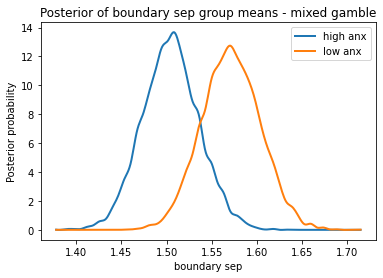

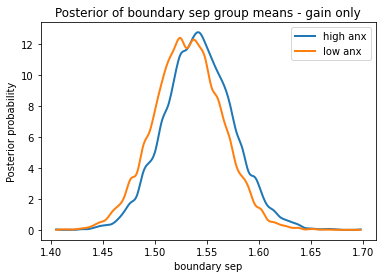

In [7]:
a_hia_101, a_hia_102 = model_hia.nodes_db.node[['a(101)', 'a(102)']]
a_loa_101, a_loa_102 = model_loa.nodes_db.node[['a(101)', 'a(102)']]

probabilities(a_hia_101, a_loa_101, a_hia_102, a_loa_102, 'boundary sep')

compute_hdi(a_hia_101, a_loa_101, a_hia_102, a_loa_102, 'boundary sep')

plot_posteriors(a_hia_101, a_loa_101, a_hia_102, a_loa_102, 'boundary sep')

# Analise t

non dec time mixed-gamble P(High Anx > Low Anx) = 0.185
non dec time gain-only P(High Anx > Low Anx) = 0.048

mixed gamble
non dec time 0.95 HDI high anx = [0.64264773 0.73469246]
non dec time 0.95 HDI low anx = [0.66651218 0.77636581]
non dec time 0.95 HDI difference = [-0.10449321  0.03988071]

gain only
non dec time 0.95 HDI high anx = [0.6392     0.73110868]
non dec time 0.95 HDI low anx = [0.69051743 0.80107717]
non dec time 0.95 HDI difference = [-0.12966533  0.0140921 ]


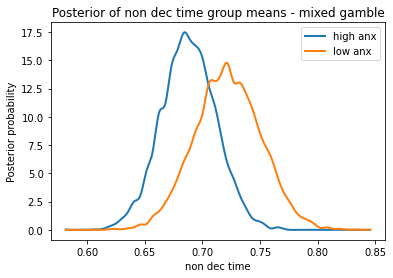

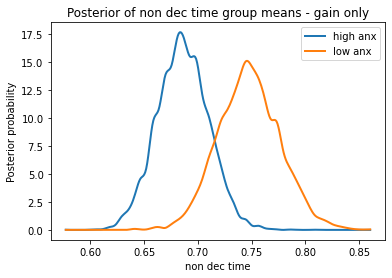

In [8]:
t_hia_101, t_hia_102 = model_hia.nodes_db.node[['t(101)', 't(102)']]
t_loa_101, t_loa_102 = model_loa.nodes_db.node[['t(101)', 't(102)']]

probabilities(t_hia_101, t_loa_101, t_hia_102, t_loa_102, 'non dec time')

compute_hdi(t_hia_101, t_loa_101, t_hia_102, t_loa_102, 'non dec time')

plot_posteriors(t_hia_101, t_loa_101, t_hia_102, t_loa_102, 'non dec time')

# Analise v

In [9]:
# v_hia_101, v_hia_102 = model_hia.nodes_db.node[['v(101)', 'v(102)']]
# v_loa_101, v_loa_102 = model_loa.nodes_db.node[['v(101)', 'v(102)']]

# probabilities(v_hia_101, v_loa_101, v_hia_102, v_loa_102, 'drift rate')

# compute_hdi(v_hia_101, v_loa_101, v_hia_102, v_loa_102, 'drift rate')

# plot_posteriors(v_hia_101, v_loa_101, v_hia_102, v_loa_102, 'drift rate')

# Analise z

starting point mixed-gamble P(High Anx > Low Anx) = 0.034
starting point gain-only P(High Anx > Low Anx) = 0.838

mixed gamble
starting point 0.95 HDI high anx = [0.49483081 0.53651014]
starting point 0.95 HDI low anx = [0.52282404 0.56779152]
starting point 0.95 HDI difference = [-0.05949137  0.00111493]

gain only
starting point 0.95 HDI high anx = [0.5226934  0.56625035]
starting point 0.95 HDI low anx = [0.50543954 0.55233385]
starting point 0.95 HDI difference = [-0.01589713  0.04805698]


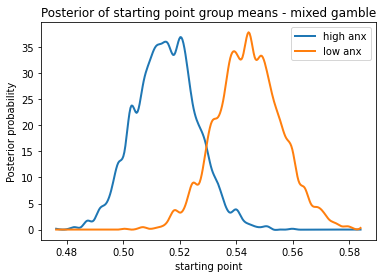

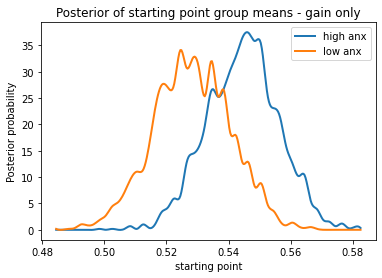

0.5154392679862386 0.5441705443290477


In [20]:
z_hia_101, z_hia_102 = model_hia.nodes_db.node[['z(101)', 'z(102)']]
z_loa_101, z_loa_102 = model_loa.nodes_db.node[['z(101)', 'z(102)']]

probabilities(z_hia_101, z_loa_101, z_hia_102, z_loa_102, 'starting point')

compute_hdi(z_hia_101, z_loa_101, z_hia_102, z_loa_102, 'starting point')

plot_posteriors(z_hia_101, z_loa_101, z_hia_102, z_loa_102, 'starting point')

print(z_hia_101.trace().mean(), z_loa_101.trace().mean())

# Extract params

In [11]:
def extract_params(model, contains=None):
    stats = model.gen_stats()
    if contains is not None:
        out = stats[stats.index.str.contains(contains,na=False)]
    else:
        out = stats
    return out 

def params(model, params=['a','t','v','z'], trials='101'):
    df = pd.DataFrame(columns=[f'{p}_{trials}' for p in params])
    out = []
    for param in params:
        ps = extract_params(model, f'{param}_subj\({trials}\)')
        # rename index to only subjID
        ps = ps.rename(lambda x: x[-16:])
        # store mean in the right column
        df[f'{param}_{trials}'] = ps['mean']
    return df

In [12]:
loa_101 = params(model_loa, params=['a','t','z'], trials='101')
loa_102 = params(model_loa, params=['a','t','z'], trials='102')

hia_101 = params(model_hia, params=['a','t','z'], trials='101')
hia_102 = params(model_hia, params=['a','t','z'], trials='102')

In [13]:
df_all_101 = pd.concat([loa_101, hia_101], axis = 0)
df_all_102 = pd.concat([loa_102, hia_102], axis = 0)

In [14]:
def pearsons_r(x, y):
    h,p = scipy.stats.pearsonr(x,y)
    print(f'h {h:.4f} - p {p:.4f}')

In [15]:
pearsons_r(df_all_101['a_101'], df_all_101['t_101'])
pearsons_r(df_all_101['a_101'], df_all_101['z_101'])
pearsons_r(df_all_101['t_101'], df_all_101['z_101'])

h 0.0576 - p 0.5407
h 0.1752 - p 0.0611
h -0.0250 - p 0.7910


In [16]:
pearsons_r(df_all_102['a_102'], df_all_102['t_102'])
pearsons_r(df_all_102['a_102'], df_all_102['z_102'])
pearsons_r(df_all_102['t_102'], df_all_102['z_102'])

h 0.1967 - p 0.0351
h -0.2058 - p 0.0274
h -0.1849 - p 0.0479


# Merge dataset

In [17]:

df_all = pd.merge(df_all_101, df_all_102, left_index=True, right_index=True)

data = pd.read_csv('../data/data_anx_gad7_prior.csv')

data_new = pd.merge(data, df_all, left_on='id', right_index=True)


In [18]:

pearsons_r(data_new['gad7'], data_new['a_101'])
pearsons_r(data_new['gad7'], data_new['t_101'])
pearsons_r(data_new['gad7'], data_new['z_101'])

pearsons_r(data_new['trait_anx'], data_new['a_101'])
pearsons_r(data_new['trait_anx'], data_new['t_101'])
pearsons_r(data_new['trait_anx'], data_new['z_101'])

h -0.1083 - p 0.2494
h -0.0949 - p 0.3131
h -0.1707 - p 0.0682
h -0.0383 - p 0.6848
h -0.0962 - p 0.3066
h -0.1162 - p 0.2160
